<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Data-Profiling" data-toc-modified-id="Data-Profiling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Profiling</a></span></li><li><span><a href="#Data-Processing-for-Modelling" data-toc-modified-id="Data-Processing-for-Modelling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Processing for Modelling</a></span></li><li><span><a href="#Save-the-clean-data" data-toc-modified-id="Save-the-clean-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save the clean data</a></span></li></ul></div>

# Description
In this project we use the openml dataset of French Motor Vehicle Insurance Claims.

Data Source  
- [Frequency Data](https://www.openml.org/d/41214)
- [Severence Data](https://www.openml.org/d/41215)

The frequency dataset has 12 columns and 678,013 rows.  
The severence dataset has 2 columns and 26,639 rows.  

![](../images/freq_01.png)
![](../images/freq_02.png)
![](../images/sev_01.png)


# Load the libraries

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import sklearn
import matplotlib.pyplot as plt
sns.set()

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly
%load_ext watermark
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
pandas           1.1.0
numpy            1.18.4
pandas_profiling 2.9.0
scipy            1.4.1
autopep8         1.5.2
json             2.0.9
sklearn          0.23.1
seaborn          0.11.0



# Load the data

In [83]:
df_freq = pd.read_csv('../data/raw/freMTPL2freq.csv', nrows=100_000)
print(df_freq.shape)
df_freq.head(2).append(df_freq.tail(2))

(100000, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
99998,1019554.0,0,1.00,C,7,9,44,50,B1,Regular,191,R24
99999,1019556.0,0,1.00,E,4,12,53,50,B1,Regular,4116,R24


In [84]:
# we need to make id column integer and set as index

df_freq['IDpol'] = df_freq['IDpol'].astype(np.int)
df_freq.set_index('IDpol', inplace=True)

In [85]:
df_freq.head(2)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
IDpol,,,,,,,,,,,
1,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
3,1,0.77,D,5,0,55,50,B12,Regular,1217,R82


In [86]:
# now we will read severity data.

In [87]:
df_sev = pd.read_csv('../data/raw/freMTPL2sev.csv')
print(df_sev.shape)
df_sev.head(2).append(df_sev.tail(2))

(26639, 2)


,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
26637,2222064,767.55
26638,2254065,1500.00


In [88]:
# we will sum insurance claim per policy ID
df_sev = df_sev.groupby('IDpol').sum()
df_sev.shape

(24950, 1)

In [89]:
df_sev.head(2)

,ClaimAmount
IDpol,
139,303.00
190,1981.84


In [90]:
# join the freq and severity data

In [91]:
df = df_freq.join(df_sev, how='left')
df.head(2)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,NaN
3,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,NaN


# Data Cleaning

In [92]:
df['ClaimAmount'] = df['ClaimAmount'].fillna(0)

In [93]:
df.head(2).append(df.tail(2)).append(df.dtypes,ignore_index=True)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1,0.1,D,5,0,55,50,B12,Regular,1217,R82,0
1,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,0
2,0,1,C,7,9,44,50,B1,Regular,191,R24,0
3,0,1,E,4,12,53,50,B1,Regular,4116,R24,0
4,int64,float64,object,int64,int64,int64,int64,object,object,int64,object,float64


In [94]:
# severity model needs claimAmount > 0 (stritctly positive)
# make all claim numbers 0 if claim amount is 0

df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

In [95]:
# clip possible outlier values and wrong data entries
df["ClaimNb"].value_counts().sort_index()

0    95262
1     4544
2      183
3        9
4        1
5        1
Name: ClaimNb, dtype: int64

In [96]:
df['ClaimNb'] = df['ClaimNb'].clip(upper=4)

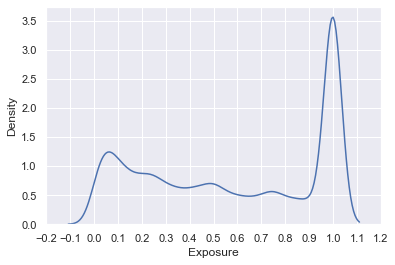

In [97]:
sns.kdeplot(df.Exposure)
plt.xticks(np.arange(-0.2,1.3,0.1));

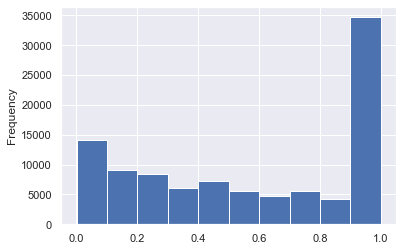

In [98]:
df['Exposure'].plot.hist(bins=10)

In [99]:
df.Exposure.describe()
# unlike kde plot shows, exposure has NO NEGATIVE values.

count    100000.000000
mean          0.583756
std           0.367475
min           0.002732
25%           0.220000
50%           0.590000
75%           1.000000
max           1.000000
Name: Exposure, dtype: float64

In [100]:
# we will clip upper values from 0.9

In [101]:
df['Exposure'] = df['Exposure'].clip(upper=0.9)

In [102]:
df["ClaimAmount"].describe()

count    1.000000e+05
mean     1.098624e+02
std      4.793431e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.404186e+06
Name: ClaimAmount, dtype: float64

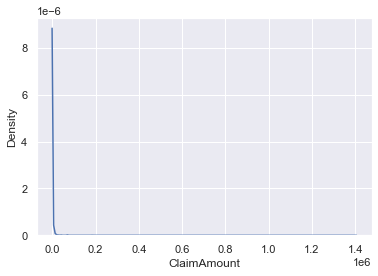

In [103]:
sns.kdeplot(df['ClaimAmount'])

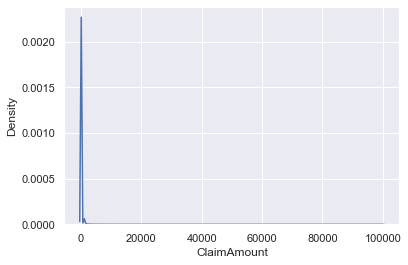

In [104]:
sns.kdeplot(df['ClaimAmount'].clip(upper=100_000)) # 0.1e6

# 100k is reasonalbe max amount, clip at that amount

In [105]:
df['ClaimAmount'] = df['ClaimAmount'].clip(upper=100_000)

In [106]:
# for frequency modelling we need these features.

df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

df[df.ClaimAmount > 0].head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
139,1,0.75,F,7,1,61,50,B12,Regular,27000,R11,303.00,404.000000,1.333333,303.00
190,1,0.14,B,12,5,50,60,B12,Diesel,56,R25,1981.84,14156.000000,7.142857,1981.84
414,1,0.14,E,4,0,36,85,B12,Regular,4792,R11,1456.55,10403.928571,7.142857,1456.55
424,2,0.62,F,10,0,51,100,B12,Regular,27000,R11,10834.00,17474.193548,3.225806,5417.00
463,1,0.31,A,5,0,45,50,B12,Regular,12,R73,3986.67,12860.225806,3.225806,3986.67


# Data Profiling

In [107]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(df)

exist = True
if not exist:
    profile.to_file(output_file="../reports/html/pandas_profiling_report.html")

# Data Processing for Modelling

In [108]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [109]:
from sklearn import set_config

set_config(display='diagram')

In [129]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)


cols_ohe_before = ["VehBrand", "VehPower", "VehGas", "Region", "Area"]
cols_kbin_before = ["VehAge", "DrivAge"]
cols_log_scale = ["Density"]
cols_pass =  ["BonusMalus"]

# NOTE: make names of columns in same order as in pipeline
# cols_ohe will be obtained after fitting column transformer.
# cols_ohe + cols_bin + cols_log_scale + cols_pass

ct = ColumnTransformer(
    [
        
        # ohe
        # (note: always make ohe first item to get feature names)
        ("ohe", OneHotEncoder(handle_unknown='ignore'), cols_ohe_before),
    
        # binning
        ("kbin", KBinsDiscretizer(n_bins=8,encode='onehot',strategy='quantile'),cols_kbin_before),
        
        # log and scale
        ("log_scale", log_scale_transformer,cols_log_scale),
        
        # keep these
        ("pass", "passthrough",cols_pass),
    ],
    remainder="drop",
)
ct

ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['VehBrand', 'VehPower', 'VehGas', 'Region',
                                  'Area']),
                                ('kbin', KBinsDiscretizer(n_bins=8),
                                 ['VehAge', 'DrivAge']),
                                ('log_scale',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Density']),
                                ('pass', 'passthrough', ['BonusMalus'])])

In [130]:
X = ct.fit_transform(df)
df.shape, X.shape

((100000, 15), (100000, 71))

In [134]:
# we make ohe first tuple of transformer, so first index is 0
# in ohe transformer, 0 is name, 1 is actual transformer object,
# so, second index is 1
# then, we can get feature names.

cols_ohe_after = ct.transformers_[0][1].get_feature_names().tolist()

kbin_n_bins = ct.transformers_[1][1].n_bins_[0]
cols_kbin_after = [ str(i) + '_' + str(j) for i in cols_kbin_before for j in range(kbin_n_bins)]

feature_names_after = cols_ohe_after + cols_kbin_after + cols_log_scale + cols_pass

print(f"shape df : {df.shape}")
print(f"shape X  : {X.shape}")
print(f"len feature_names_after: {len(feature_names_after)}")
print(feature_names_after)

shape df : (100000, 15)
shape X  : (100000, 71)
len feature_names_after: 71
['x0_B1', 'x0_B10', 'x0_B11', 'x0_B12', 'x0_B13', 'x0_B14', 'x0_B2', 'x0_B3', 'x0_B4', 'x0_B5', 'x0_B6', 'x1_4', 'x1_5', 'x1_6', 'x1_7', 'x1_8', 'x1_9', 'x1_10', 'x1_11', 'x1_12', 'x1_13', 'x1_14', 'x1_15', 'x2_Diesel', 'x2_Regular', 'x3_R11', 'x3_R21', 'x3_R22', 'x3_R23', 'x3_R24', 'x3_R25', 'x3_R26', 'x3_R31', 'x3_R41', 'x3_R42', 'x3_R43', 'x3_R52', 'x3_R53', 'x3_R54', 'x3_R72', 'x3_R73', 'x3_R74', 'x3_R82', 'x3_R83', 'x3_R91', 'x3_R93', 'x3_R94', 'x4_A', 'x4_B', 'x4_C', 'x4_D', 'x4_E', 'x4_F', 'VehAge_0', 'VehAge_1', 'VehAge_2', 'VehAge_3', 'VehAge_4', 'VehAge_5', 'VehAge_6', 'VehAge_7', 'DrivAge_0', 'DrivAge_1', 'DrivAge_2', 'DrivAge_3', 'DrivAge_4', 'DrivAge_5', 'DrivAge_6', 'DrivAge_7', 'Density', 'BonusMalus']


In [135]:
np.array(X[0].todense())[0][-5:] # last elements of first row

array([ 0.        ,  1.        ,  0.        ,  0.69864446, 50.        ])

In [136]:
feature_names_before = cols_ohe_before + cols_kbin + cols_log_scale + cols_pass

df[feature_names_before].head(2)

,VehBrand,VehPower,VehGas,Region,Area,VehAge,DrivAge,Density,BonusMalus
IDpol,,,,,,,,,
1,B12,5,Regular,R82,D,0,55,1217,50
3,B12,5,Regular,R82,D,0,55,1217,50


# Save the clean data

In [137]:
import scipy
import json

In [138]:
df.shape

(100000, 15)

In [139]:
df.head(2)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
1,0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
3,0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0


In [140]:
# df.to_csv('../data/processed/clean_data.csv.zip',compression='zip',index=False)
# this method did not work in google colab.

In [141]:
df.to_csv('../data/processed/clean_data.csv',index=False)

In [142]:
# !zip  ../data/processed/clean_data.csv.zip ../data/processed/clean_data.csv
# do not do this, this will create folders and then files.
# cd to that directory and then zip it.

In [143]:
%%bash
cd ../data/processed
zip clean_data.csv.zip clean_data.csv
rm clean_data.csv
cd -

updating: clean_data.csv (deflated 84%)
/Users/poudel/github/Project_French_Motor_Claims/notebooks


In [144]:
type(X)

scipy.sparse.csr.csr_matrix

In [145]:
# scipy.sparse.save_npz?

In [147]:
scipy.sparse.save_npz('../data/processed/X.npz',X)

In [148]:
X_dense = X.todense()
df_X = pd.DataFrame(data=X_dense, columns=feature_names_after)

df_X.to_csv('../data/processed/X.csv',index=False)

(100000, 71)

In [162]:
%%bash

FILE="X.csv"
cd ../data/processed/

zip "$FILE".zip "$FILE"

du -sh "$FILE"
du -sh "$FILE".zip

rm "$FILE"
cd -

updating: X.csv (deflated 95%)
 29M	X.csv
1.3M	X.csv.zip
/Users/poudel/github/Project_French_Motor_Claims/notebooks


In [163]:
# save the features json

In [164]:
data_json = dict(
    cols_ohe_before = ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
    cols_kbin = ["VehAge", "DrivAge"],
    cols_log_scale = ["Density"],
    cols_pass =  ["BonusMalus"],
    feature_names_before = feature_names_before,
    feature_names_after = feature_names_after,
    desc="""
    df['ClaimNb'] = df['ClaimNb'].clip(upper=4)
    df['Exposure'] = df['Exposure'].clip(upper=0.9)
    df['ClaimAmount'] = df['ClaimAmount'].clip(upper=100_000)
    KBinsDiscretizer : n_bins=8

    """
    
)

In [165]:
with open("../data/processed/features.json","w") as fo:
    json.dump(data_json, fo)